## Writing Efficient Queries
A volte non importa se la tua query è efficiente o meno. Ad esempio, potresti scrivere una query che prevedi venga eseguita solo una volta e potrebbe funzionare su un piccolo set di dati. In questo caso, tutto ciò che ti dà la risposta di cui hai bisogno andrà bene.

Ma che dire delle query che verranno eseguite molte volte, come una query che fornisce dati a un sito Web? Questi devono essere efficienti in modo da non lasciare gli utenti in attesa del caricamento del tuo sito web.

O che dire delle query su enormi set di dati? Questi possono essere lenti e costare un sacco di soldi a un'azienda se sono scritti male.

La maggior parte dei sistemi di database dispone di un **Query Optimizer** che tenta di interpretare/eseguire la query nel modo più efficace possibile. Ma diverse strategie possono comunque produrre enormi risparmi in molti casi.

### Alcune funzioni utili
Utilizzeremo due funzioni per confrontare l'efficienza di query diverse:

`show_amount_of_data_scanned()` mostra la quantità di dati utilizzata dalla query.
`show_time_to_run()` stampa il tempo necessario per l'esecuzione della query.

In [1]:
from google.cloud import bigquery
from time import time

# chiave mia
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="D:/Users/Alessio/sql-kaggle-355310-de53f901ac8a.json"

client = bigquery.Client()

def show_amount_of_data_scanned(query):
    # dry_run lets us see how much data the query uses without running it
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))

### Strategies
1. Seleziona solo le colonne desiderate.
Si è tentati di avviare query con `SELECT * FROM ...`. È conveniente perché non è necessario pensare a quali colonne sono necessarie. Ma può essere molto inefficiente.

Questo è particolarmente importante se ci sono campi di testo che non ti servono, perché i campi di testo tendono ad essere più grandi di altri campi.

In [2]:
star_query = "SELECT * FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(star_query)

basic_query = "SELECT size, binary FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(basic_query)

Data processed: 2647.394 GB
Data processed: 2.507 GB


In questo caso, vediamo una riduzione di 1000 volte i dati scansionati per completare la query, perché i dati grezzi contenevano un campo di testo 1000 volte più grande dei campi di cui potremmo aver bisogno.

2. Leggere meno dati.
Entrambe le query sottostanti calcolano la durata media (in secondi) dei viaggi in bicicletta di sola andata nella città di San Francisco.

In [3]:
more_data_query = """
                  SELECT MIN(start_station_name) AS start_station_name,
                      MIN(end_station_name) AS end_station_name,
                      AVG(duration_sec) AS avg_duration_sec
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_id != end_station_id 
                  GROUP BY start_station_id, end_station_id
                  LIMIT 10
                  """
show_amount_of_data_scanned(more_data_query)

less_data_query = """
                  SELECT start_station_name,
                      end_station_name,
                      AVG(duration_sec) AS avg_duration_sec                  
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_name != end_station_name
                  GROUP BY start_station_name, end_station_name
                  LIMIT 10
                  """
show_amount_of_data_scanned(less_data_query)

Data processed: 0.076 GB
Data processed: 0.06 GB


Poiché esiste una relazione 1:1 tra l'ID stazione e il nome della stazione, non è necessario utilizzare le colonne `start_station_id` e `end_station_id` nella query. Utilizzando solo le colonne con gli ID stazione, scansioniamo meno dati.

3. Evita N:N JOIN
La maggior parte delle `JOIN` che hai eseguito in questo corso sono state `JOIN 1:1`. In questo caso, ogni riga di ogni tabella ha al massimo una corrispondenza nell'altra tabella.

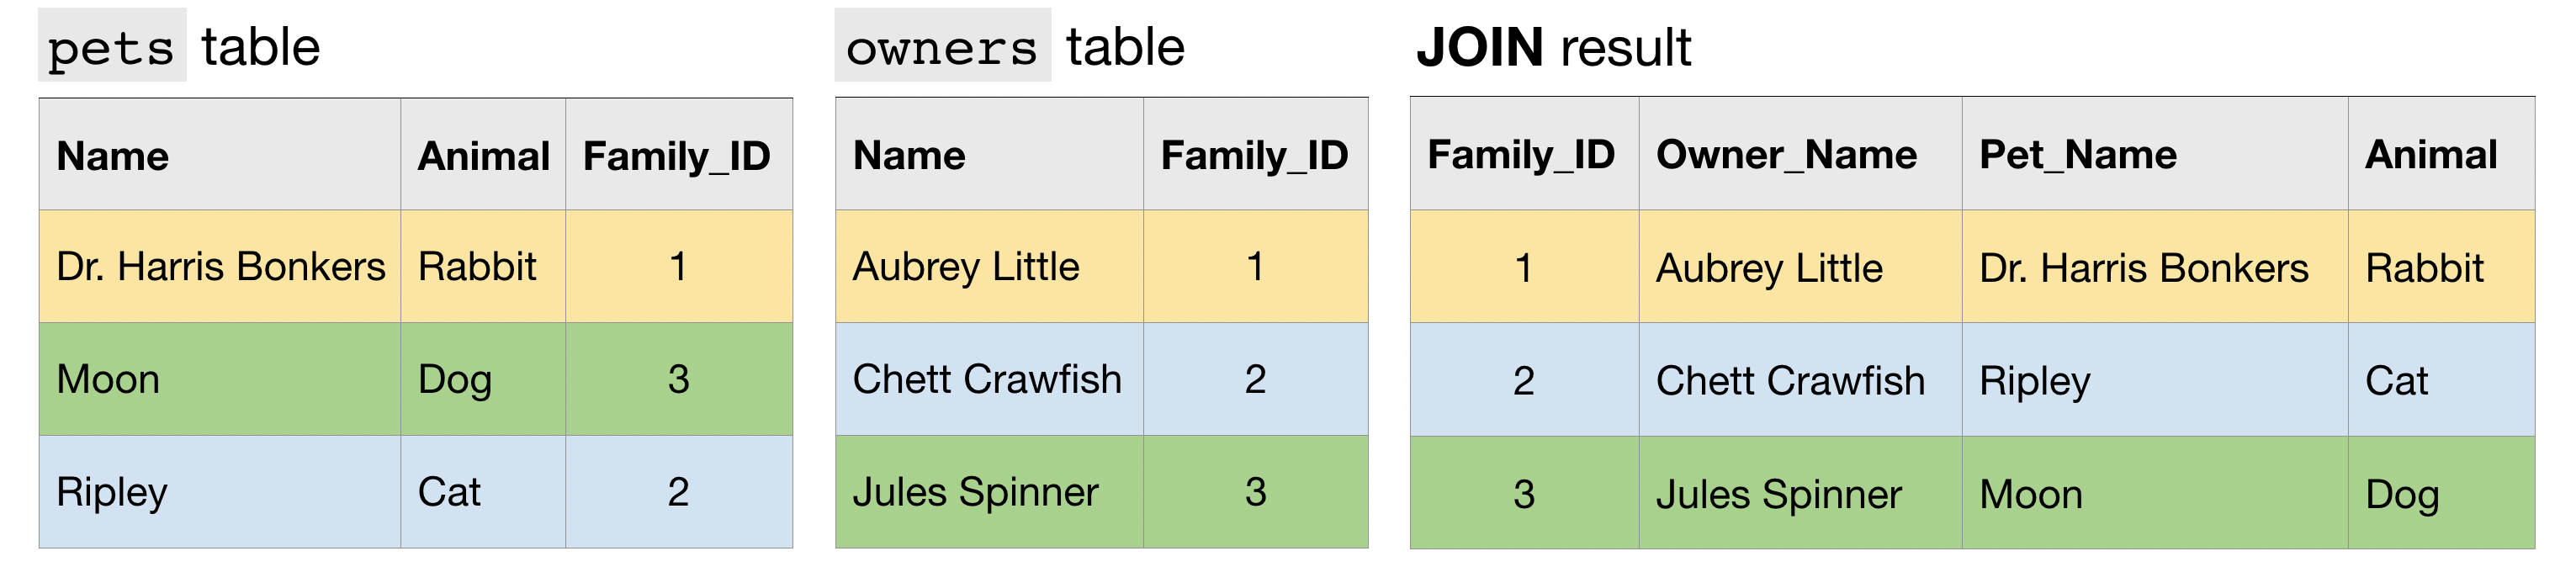

Un altro tipo di `JOIN` è un `JOIN N:1`. Qui, ogni riga in una tabella corrisponde potenzialmente a molte righe nell'altra tabella.

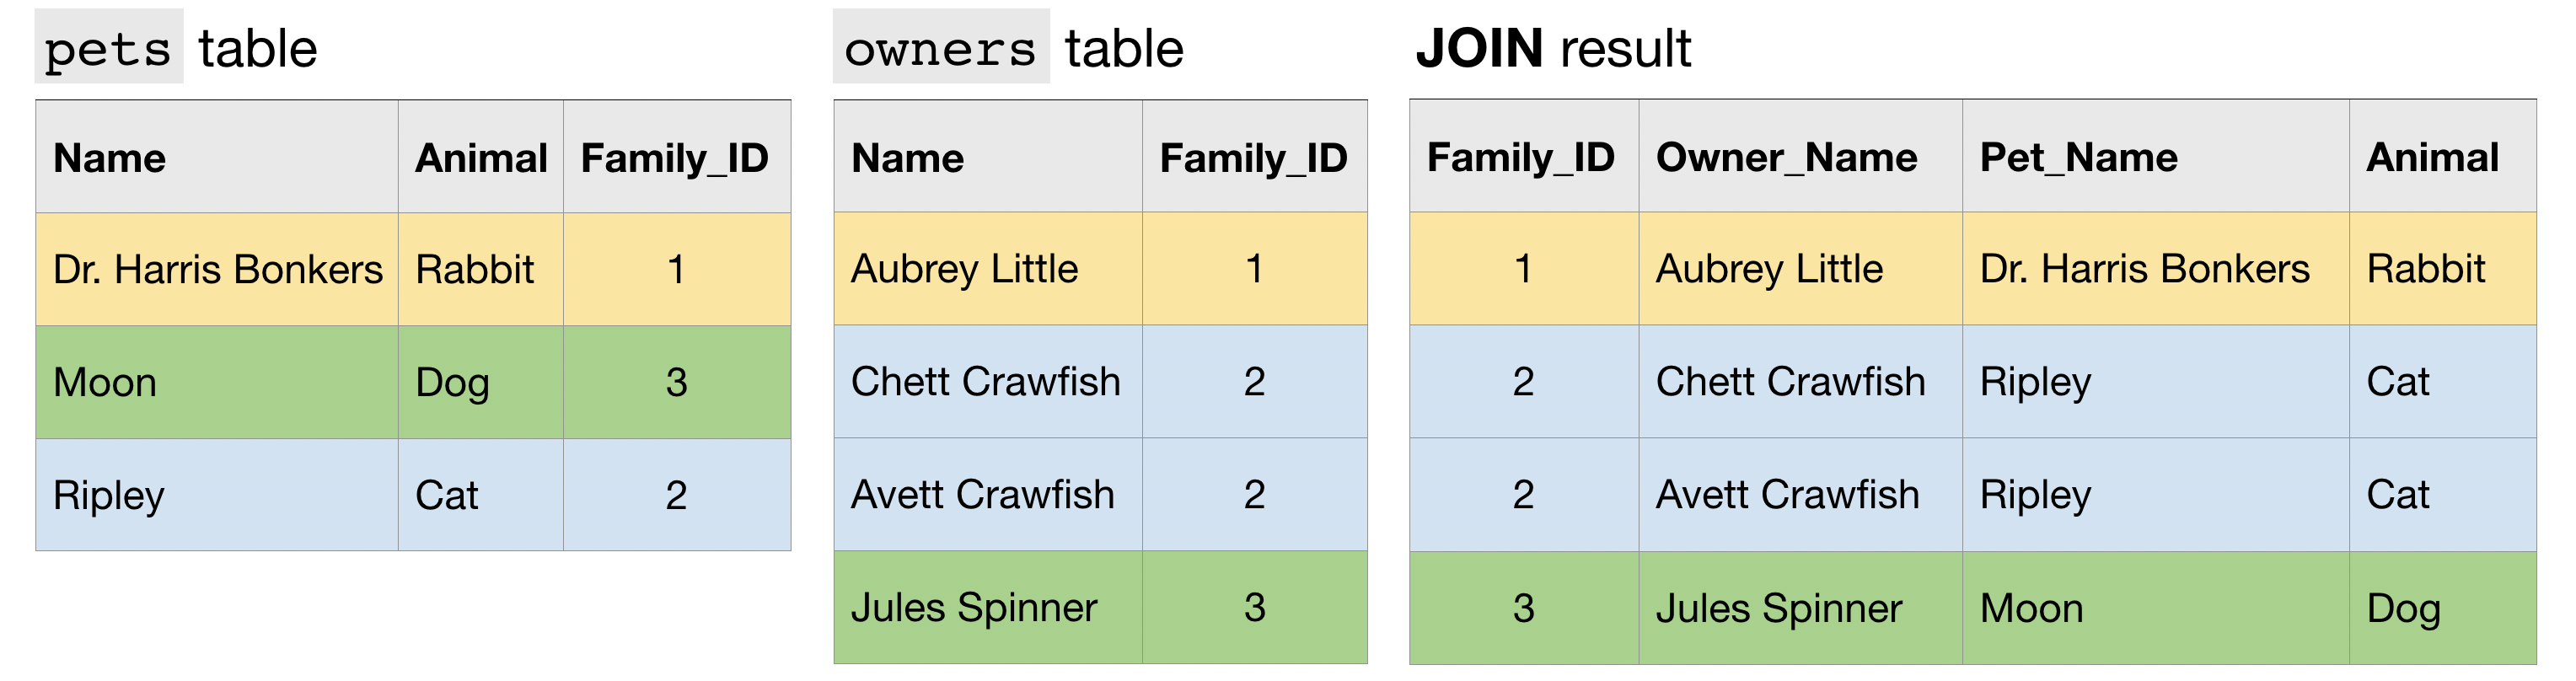

Infine, un `N:N JOIN` è quello in cui un gruppo di righe in una tabella può corrispondere a un gruppo di righe nell'altra tabella. Si noti che in generale, a parità di condizioni, questo tipo di JOIN produce una tabella con molte più righe rispetto a una delle due tabelle (originali) che vengono unite.

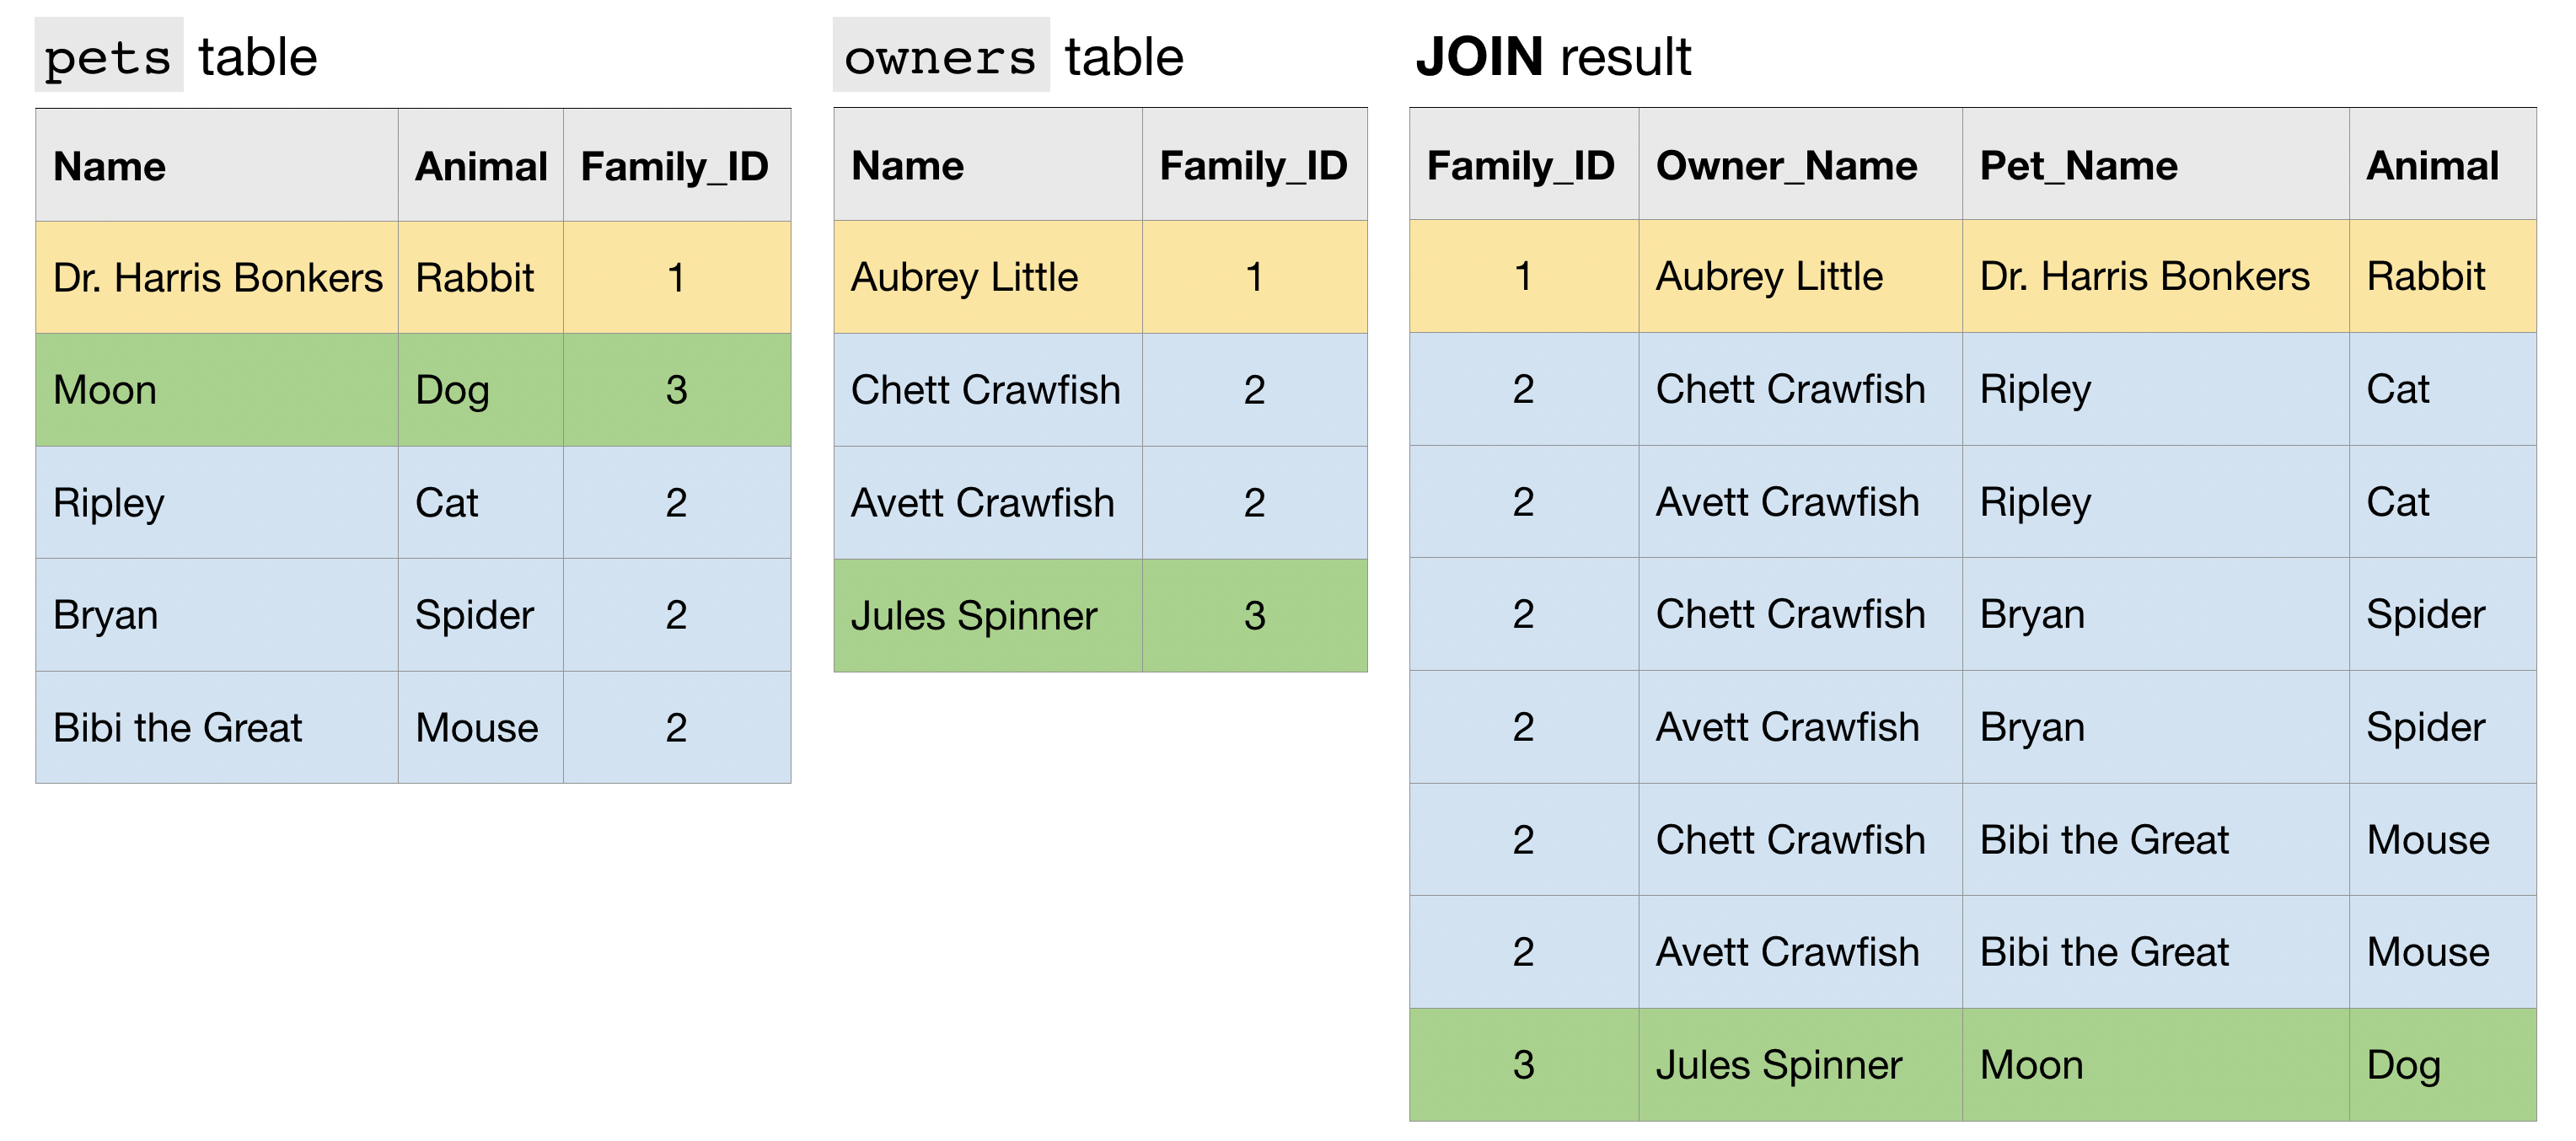

Ora lavoreremo con un esempio da un set di dati reale. Entrambi gli esempi seguenti contano il numero di committenti distinti e il numero di file in diversi repository GitHub.

In [4]:
big_join_query = """
                 SELECT repo,
                     COUNT(DISTINCT c.committer.name) as num_committers,
                     COUNT(DISTINCT f.id) AS num_files
                 FROM `bigquery-public-data.github_repos.commits` AS c,
                     UNNEST(c.repo_name) AS repo
                 INNER JOIN `bigquery-public-data.github_repos.files` AS f
                     ON f.repo_name = repo
                 WHERE f.repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                 GROUP BY repo
                 ORDER BY repo
                 """
show_time_to_run(big_join_query)

small_join_query = """
                   WITH commits AS
                   (
                   SELECT COUNT(DISTINCT committer.name) AS num_committers, repo
                   FROM `bigquery-public-data.github_repos.commits`,
                       UNNEST(repo_name) as repo
                   WHERE repo IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   ),
                   files AS 
                   (
                   SELECT COUNT(DISTINCT id) AS num_files, repo_name as repo
                   FROM `bigquery-public-data.github_repos.files`
                   WHERE repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   )
                   SELECT commits.repo, commits.num_committers, files.num_files
                   FROM commits 
                   INNER JOIN files
                       ON commits.repo = files.repo
                   ORDER BY repo
                   """

show_time_to_run(small_join_query)

Time to run: 13.531 seconds
Time to run: 3.233 seconds


La prima query ha un `N:N JOIN` grande. Riscrivendo la query per ridurre la dimensione del `JOIN`, vediamo che funziona molto più velocemente.

## Esercizi
Ora utilizzerai ciò che hai appreso nel tutorial precedente per migliorare l'efficienza di diverse query.

Prima di iniziare, esegui la cella seguente per impostare tutto.

In [5]:
# Set up feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.sql_advanced.ex4 import *
print("Setup Complete")

Setup Complete


### Domanda 1
**Lavori per Pet Costumes International**

Devi scrivere tre domande questo pomeriggio. Hai abbastanza tempo per scrivere versioni funzionanti di tutti e tre, ma solo abbastanza tempo per pensare all'ottimizzazione di uno di essi. Quale di queste query vale maggiormente la pena ottimizzare?

1. Un ingegnere del software ha scritto un'app per il reparto spedizioni, per vedere quali articoli devono essere spediti e in quale corsia del magazzino andare per quegli articoli. Vuole che tu scriva la domanda. Coinvolgerà i dati che sono memorizzati in una tabella "ordini", una tabella "spedizioni" e una tabella "posizione magazzino". I dipendenti del reparto spedizioni apriranno questa app su un tablet, premeranno Aggiorna e i risultati della tua query verranno mostrati in una bella interfaccia in modo che possano vedere quali costumi inviare e dove.


2. Il CEO desidera un elenco di tutte le recensioni e i reclami dei clienti... che sono convenientemente archiviati in un'unica tabella "recensioni". Alcune delle recensioni sono davvero lunghe... perché le persone adorano i tuoi costumi da pirata per i pappagalli e non riescono a smettere di scrivere di quanto siano carini.


3. I proprietari di cani stanno diventando più protettivi che mai. Quindi il tuo dipartimento di ingegneria ha realizzato costumi con localizzatori GPS incorporati e dispositivi di comunicazione wireless. Inviano le coordinate dei costumi al tuo database una volta al secondo. Quindi hai un sito Web in cui i proprietari possono trovare la posizione dei loro cani (o almeno i costumi che hanno per quei cani). Affinché questo servizio funzioni, è necessaria una query che mostri la posizione più recente per tutti i costumi di proprietà di un determinato essere umano. Ciò comporterà i dati in una tabella `CostumeLocations` così come in una tabella `CostumeOwners`.

Quindi, quale di questi potrebbe trarre il massimo vantaggio dall'essere scritto in modo efficiente? Imposta il valore della variabile `query_to_optimize` di seguito su uno tra `1`, `2` o `3`. (La tua risposta dovrebbe avere il tipo **intero**.)

In [6]:
# Fill in your answer
query_to_optimize = 3

# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 


`query_to_optimize = 3`

Why **3**: Because data is sent for each costume at each second, this is the query that is likely to involve the most data (by far). And it will be run on a recurring basis. So writing this well could pay off on a recurring basis.

Why not **1**: This is the second most valuable query to optimize. It will be run on a recurring basis, and it involves merges, which is commonly a place where you can make your queries more efficient

Why not **2**: This sounds like it will be run only one time. So, it probably doesn’t matter if it takes a few seconds extra or costs a few cents more to run that one time. Also, it doesn’t involve JOINs. While the data has text fields (the reviews), that is the data you need. So, you can’t leave these out of your select query to save computation.


### 2) Semplifica la ricerca di Mitzie!

Hai le seguenti due tabelle:

![](https://i.imgur.com/E9jikOQ.png)

La tabella `CostumeLocations` mostra i dati GPS con timestamp per tutti i costumi degli animali domestici nel database, dove `CostumeID` è un identificatore univoco per ogni costume.

La tabella `CostumeOwners` mostra chi possiede ogni costume, dove la colonna `OwnerID` contiene identificatori univoci per ogni proprietario (umano). Nota che ogni proprietario può avere più di un costume! Inoltre, ogni costume può avere più di un proprietario: ciò consente a più individui della stessa famiglia (tutti con il proprio "ID proprietario" univoco) di accedere alle posizioni dei costumi dei loro animali domestici.

Supponiamo che tu debba usare queste tabelle per ottenere la posizione corrente di un animale domestico in particolare: Mitzie the Dog è recentemente scappata inseguendo uno scoiattolo, ma per fortuna è stata vista l'ultima volta nel suo costume da hot dog!

Uno dei proprietari di Mitzie (con ID proprietario `MitzieOwnerID`) accede al tuo sito Web per estrarre le ultime posizioni di ogni costume in suo possesso. Attualmente, ottieni queste informazioni eseguendo la seguente query:

```sql
WITH LocationsAndOwners AS 
(
SELECT * 
FROM CostumeOwners co INNER JOIN CostumeLocations cl
   ON co.CostumeID = cl.CostumeID
),
LastSeen AS
(
SELECT CostumeID, MAX(Timestamp)
FROM LocationsAndOwners
GROUP BY CostumeID
)
SELECT lo.CostumeID, Location 
FROM LocationsAndOwners lo INNER JOIN LastSeen ls 
	ON lo.Timestamp = ls.Timestamp AND lo.CostumeID = ls.CostumeID
WHERE OwnerID = MitzieOwnerID
```

C'è un modo per renderlo più veloce o più economico?

In [7]:
# View the solution (Run this code cell to receive credit!)
q_2.solution()

<IPython.core.display.Javascript object>

<span style="color:#33cc99">Solution:</span> 
Yes. Working with the LocationsAndOwners table is very inefficient, because it’s a big table. There are a few options here, and which works best depends on database specifics. One likely improvement is

```
WITH CurrentOwnersCostumes AS
(
SELECT CostumeID 
FROM CostumeOwners 
WHERE OwnerID = MitzieOwnerID
),
OwnersCostumesLocations AS
(
SELECT cc.CostumeID, Timestamp, Location 
FROM CurrentOwnersCostumes cc INNER JOIN CostumeLocations cl
    ON cc.CostumeID = cl.CostumeID
),
LastSeen AS
(
SELECT CostumeID, MAX(Timestamp)
FROM OwnersCostumesLocations
GROUP BY CostumeID
)
SELECT ocl.CostumeID, Location 
FROM OwnersCostumesLocations ocl INNER JOIN LastSeen ls 
    ON ocl.timestamp = ls.timestamp AND ocl.CostumeID = ls.costumeID
```

**Why is this better?**

Instead of doing large merges and running calculations (like finding the last timestamp) for every costume, we discard the rows for other owners as the first step. So each subsequent step (like calculating the last timestamp) is working with something like 99.999% fewer rows than what was needed in the original query.

Databases have something called “Query Planners” to optimize details of how a query executes even after you write it. Perhaps some query planner would figure out the ability to do this. But the original query as written would be very inefficient on large datasets.
